In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## Importing data

In [47]:
data = pd.read_csv('datasets/articles_data_clean.csv')
source_info = pd.read_csv('datasets/source_info.csv')

In [48]:
#Reconverting dtypes object -> string
data.set_index('id', inplace=True)
objcol = data.select_dtypes('object').columns
data[objcol] = data[objcol].astype('string')

source_info.set_index('id', inplace=True)
objcol = source_info.select_dtypes('object').columns
source_info[objcol] = source_info[objcol].astype('string')

In [49]:
#Reconverting dtypes float64 -> int64
floatcol = data.select_dtypes('float64').columns
data[floatcol] = data[floatcol].astype('int64')

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10317 entries, 0 to 10436
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source_id       10317 non-null  string
 1   title           10317 non-null  string
 2   hour            10317 non-null  string
 3   top_article     10317 non-null  bool  
 4   reactions       10317 non-null  int64 
 5   comments        10317 non-null  int64 
 6   shares          10317 non-null  int64 
 7   comment_plugin  10317 non-null  int64 
dtypes: bool(1), int64(4), string(3)
memory usage: 654.9 KB


In [51]:
source_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, reuters to espn
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      12 non-null     string
 1   articles  12 non-null     int64 
dtypes: int64(1), string(1)
memory usage: 288.0+ bytes


## Batch analysis

In [52]:
data_description = data.describe().T
data_description

,count,mean,std,min,25%,50%,75%,max
reactions,10317.0,381.416788,4433.772657,0.0,0.0,1.0,43.0,354132.0
comments,10317.0,124.006591,965.436117,0.0,0.0,0.0,12.0,48490.0
shares,10317.0,196.236309,1020.775517,0.0,1.0,8.0,47.0,39422.0
comment_plugin,10317.0,0.011631,0.268301,0.0,0.0,0.0,0.0,15.0


In [53]:
#There seem to be a lot of zeroes

data_description['n_nonzero'] = data[data_description.index].applymap(lambda x: 1 if x > 0 else 0)[data_description.index].sum()
data_description

,count,mean,std,min,25%,50%,75%,max,n_nonzero
reactions,10317.0,381.416788,4433.772657,0.0,0.0,1.0,43.0,354132.0,5512
comments,10317.0,124.006591,965.436117,0.0,0.0,0.0,12.0,48490.0,4482
shares,10317.0,196.236309,1020.775517,0.0,1.0,8.0,47.0,39422.0,7833
comment_plugin,10317.0,0.011631,0.268301,0.0,0.0,0.0,0.0,15.0,50


## Source by source analysis

In [54]:
for key, item in data.groupby(['source_id']):
    print('\033[1m' + key, end='\n\033[0m')
    print(item.describe().T, end='\n\n\n\n')

abc-news
                 count        mean          std  min  25%  50%  75%      max
reactions       1139.0  301.825285  3248.008820  0.0  0.0  0.0  0.0  91311.0
comments        1139.0   90.173837   739.988366  0.0  0.0  0.0  0.0  20128.0
shares          1139.0   72.574188   736.899852  0.0  0.0  3.0  5.5  22080.0
comment_plugin  1139.0    0.000878     0.029630  0.0  0.0  0.0  0.0      1.0



al-jazeera-english
                count        mean         std  min  25%   50%   75%     max
reactions       499.0  281.382766  953.474030  0.0  0.0   4.0  66.0  9268.0
comments        499.0   92.194389  337.043835  0.0  0.0   1.0  11.0  4245.0
shares          499.0   72.206413  220.059903  0.0  9.5  18.0  43.5  2475.0
comment_plugin  499.0    0.018036    0.133215  0.0  0.0   0.0   0.0     1.0



bbc-news
                 count        mean          std  min  25%  50%    75%  \
reactions       1242.0  439.127214  4422.955716  0.0  0.0  2.0  27.00   
comments        1242.0  167.115942  1683.40298

In [55]:
#News from espn and the column comment_plugin can be dropped
data.drop(columns='comment_plugin', inplace=True)
data.drop(data[data['source_id'] == 'espn'].index, inplace=True)
source_info.drop('espn', inplace=True)

In [56]:
numcol = data.select_dtypes('int64').columns
ngraphs = numcol.size
nsources = source_info.index.size

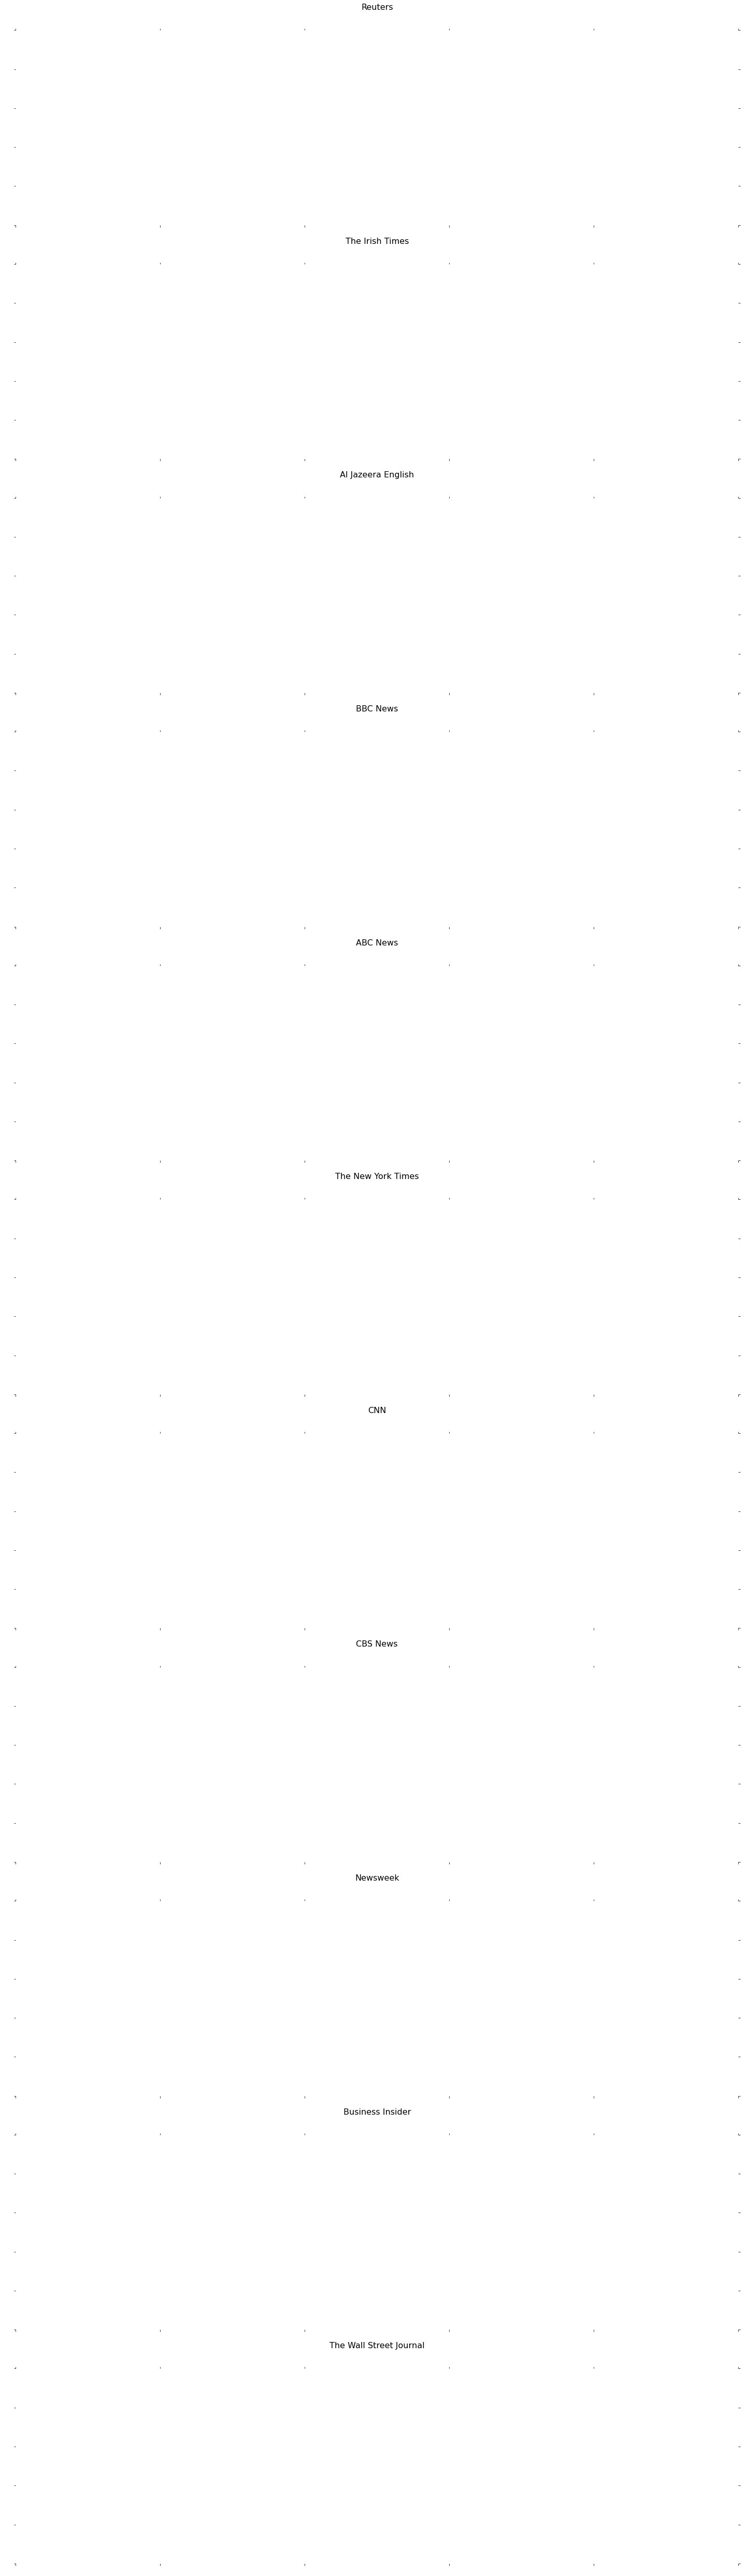

In [57]:
#Creating a figure with one axes for each news source. 
fig, big_axes = plt.subplots(figsize=(25.0, 90.0) , nrows=nsources, ncols=1) 

for row, source_ax in enumerate(big_axes, start=1):
    source_ax.set_title(source_info['name'][row -1], fontsize=16, pad=40)
    #Making row axes "invisible"
    source_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='on', bottom='off', left='off', right='off')
    source_ax._frameon = False

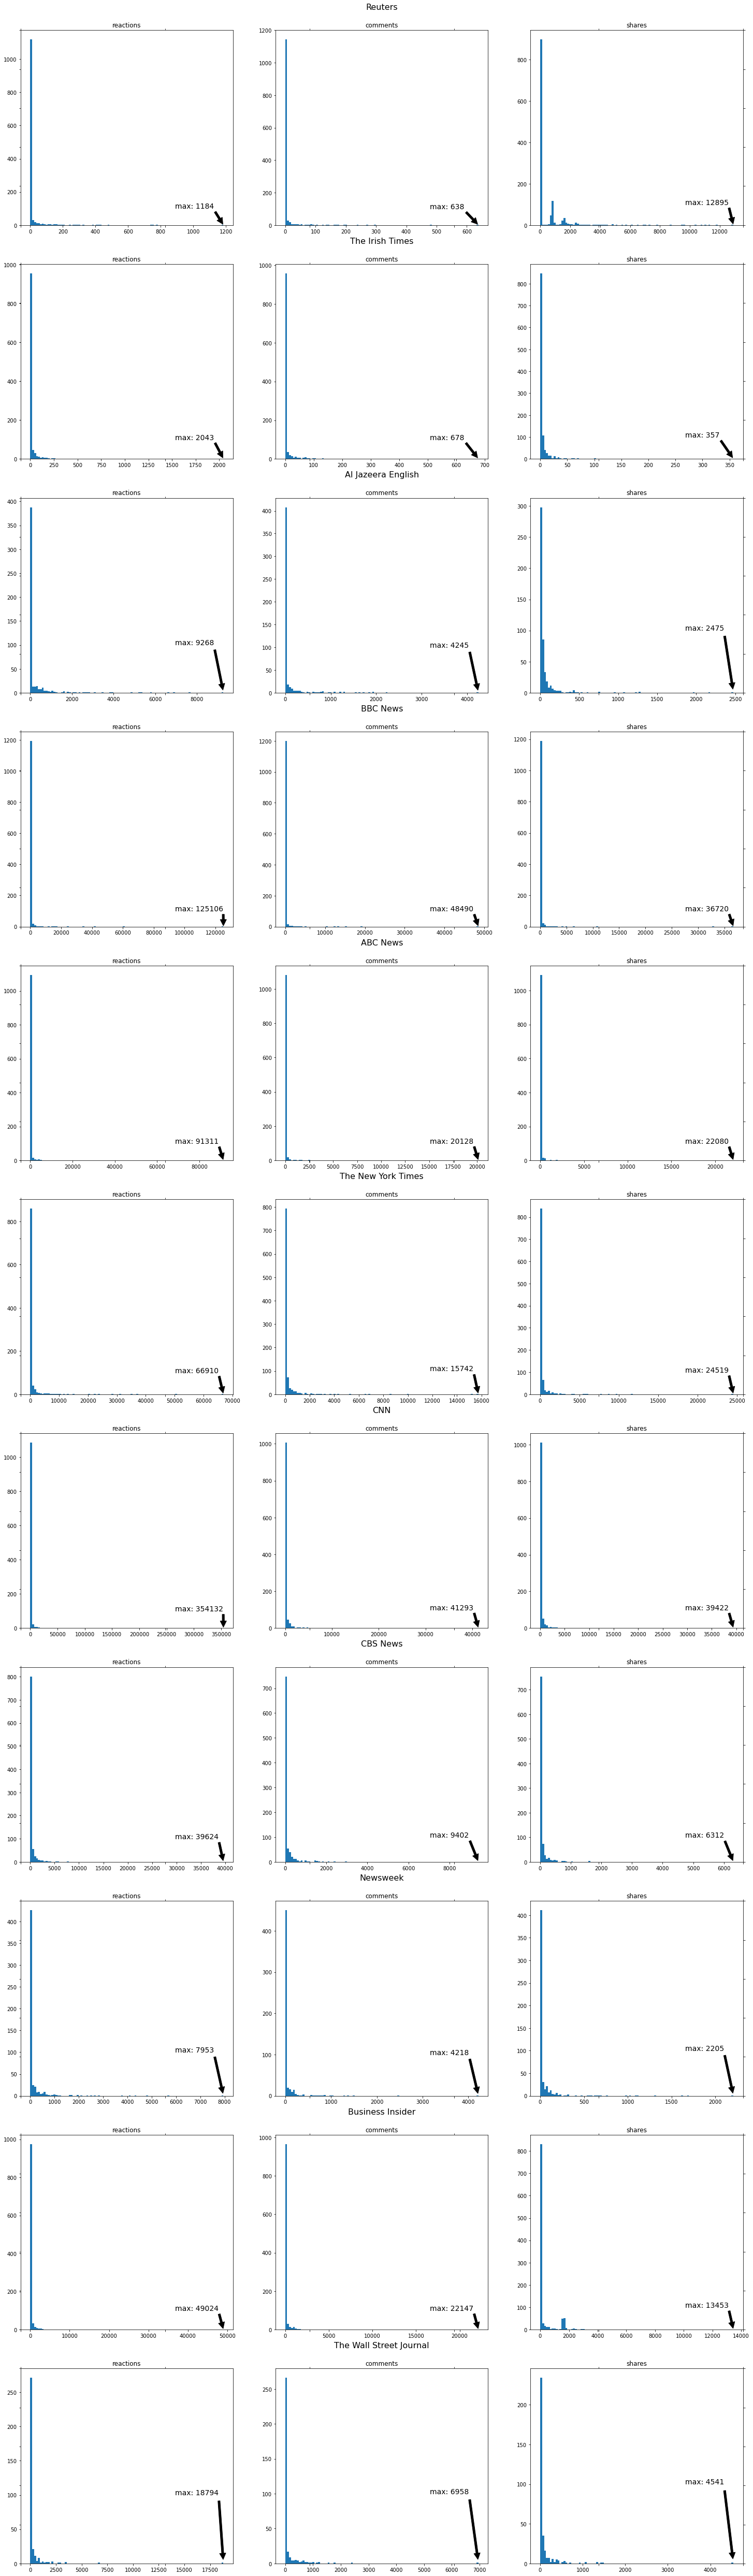

In [58]:
#Drawing the histograms
for i in range(nsources * ngraphs):
    datacol = numcol[i % ngraphs]
    datagroup = data.groupby(['source_id']).get_group(source_info.index[i // ngraphs])[datacol]
    max = datagroup.max()
    
    ax = fig.add_subplot(nsources, ngraphs, i +1)
    ax.set_title(datacol)
    ax.hist(datagroup, bins=100)
    ax.annotate('max: ' + str(max), xy=(max, 1), xytext=(max - max/4, 100), fontsize=14, arrowprops = dict(facecolor='black', shrink=0.05))
    
fig.set_facecolor('w')
fig

In [59]:
#Most of the categories for each source seem to have an outlier (a single high interaction article)
for key, item in data.groupby('source_id'):
    print(key)
    print(item.describe().T)

abc-news
            count        mean          std  min  25%  50%  75%      max
reactions  1139.0  301.825285  3248.008820  0.0  0.0  0.0  0.0  91311.0
comments   1139.0   90.173837   739.988366  0.0  0.0  0.0  0.0  20128.0
shares     1139.0   72.574188   736.899852  0.0  0.0  3.0  5.5  22080.0
al-jazeera-english
           count        mean         std  min  25%   50%   75%     max
reactions  499.0  281.382766  953.474030  0.0  0.0   4.0  66.0  9268.0
comments   499.0   92.194389  337.043835  0.0  0.0   1.0  11.0  4245.0
shares     499.0   72.206413  220.059903  0.0  9.5  18.0  43.5  2475.0
bbc-news
            count        mean          std  min  25%  50%    75%       max
reactions  1242.0  439.127214  4422.955716  0.0  0.0  2.0  27.00  125106.0
comments   1242.0  167.115942  1683.402981  0.0  0.0  0.0  12.00   48490.0
shares     1242.0  161.542673  1532.002306  0.0  1.0  8.0  36.75   36720.0
business-insider
            count        mean          std  min  25%   50%    75%      max

In [60]:
#checking for the outliers's title
from io import StringIO
outputIO = StringIO()

outputIO.write('# Titolo articoli con più interazioni per pubblicazione\n\n')

for key, item in data.groupby('source_id'):
    outputIO.write('1. [' + source_info.loc[key, 'name'] + '](#' + key + ')\n')

outputIO.write('\n')

for key, item in data.groupby('source_id'):
    source = source_info.loc[key, 'name']
    print('\033[1m' + source + '\033[0m\n')
    
    outputIO.write('## <a name=\'' + key + '\'> ' + source + '\n')
    
    catMax = item.describe().T['max']
    
    for cat in catMax.index:
        outlier = item.loc[item[cat] == catMax[cat]]

        titolo = outlier['title'].iloc[0] + ' | '
        timestamp = outlier['hour'].iloc[0]
        
        print(cat, end=': ')        
        print(titolo, end='')
        print(timestamp)
        
        outputIO.write('**' + cat + ':** ')
        outputIO.write(titolo)
        outputIO.write(timestamp + '\\\n') 
    
    print()
    
    outputIO.seek(outputIO.tell() - 2)
    outputIO.write('\n\n')
    

ABC News

reactions: Amber Guyger convicted of murder in wrong-apartment killing of innocent man | 15:48:31Z
comments: Amber Guyger convicted of murder in wrong-apartment killing of innocent man | 15:48:31Z
shares: Amber Guyger convicted of murder in wrong-apartment killing of innocent man | 15:48:31Z

Al Jazeera English

reactions: India's space hopes dashed for now with loss of lunar lander | 04:54:55Z
comments: India's space hopes dashed for now with loss of lunar lander | 04:54:55Z
shares: Kashmir: Life under siege | 05:19:14Z

BBC News

reactions: Zimbabwe ex-President Robert Mugabe dies aged 95 | 05:04:07Z
comments: Zimbabwe ex-President Robert Mugabe dies aged 95 | 05:04:07Z
shares: MPs return ahead of key Brexit vote | 14:53:39.3996878Z

Business Insider

reactions: Walmart will ban shoppers from openly carrying guns in its stores and stop selling some ammunition in response to 2 deadly shootings | 17:00:00Z
comments: Walmart will ban shoppers from openly carrying guns in its s

## Saving

In [61]:
data.to_csv('datasets/data.csv')
source_info.to_csv('datasets/info.csv')

In [62]:
fig.savefig('img/histograms_per_source.jpg', bbox_inches='tight', dpi=300)

In [63]:
with open('res/articoli_massima_interazione.md', 'w') as output_file:
    print(outputIO.getvalue(), file = output_file)

outputIO.close()